In [1]:
import sys 
import os 
from keyvars import ufiles_path
sys.path.append(ufiles_path)
import uvars
import uprocessing as up 
import utransform as ut 

import numpy as np 
import pandas as pd 
import geopandas as gpd 
import matplotlib as mpl 
import matplotlib.pyplot as plt 
from glob import glob 
import rasterio

mpl.rcParams.update({"axes.grid":True, "grid.color":"gray",
                      "grid.linestyle":'--','figure.figsize':(10,10)})
#https://github.com/Solve-Geosolutions/transform_2022/tree/master

In [2]:
os.listdir(uvars.tas_dataset_path)

['sn_w_minoccs.gpkg',
 'tasgrav_IR.tif',
 'tasgrav_IR_1VD.tif',
 'tasmag_TMI.tif',
 'tasmag_TMI_1VD.tif',
 'tasrad_K_pct.tif',
 'tasrad_Th_ppm.tif',
 'tasrad_U_ppm.tif']

In [3]:
data_dir = uvars.tas_dataset_path

point_fn = os.path.join(data_dir, 'sn_w_minoccs.gpkg')
tiffs_fn = glob(f'{data_dir}/*.tif')

<AxesSubplot:>

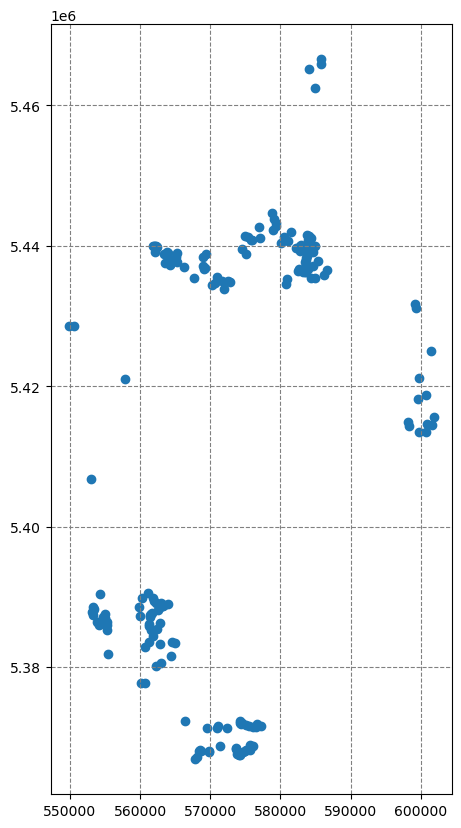

In [4]:
gdf = gpd.read_file(point_fn)
gdf.plot()

In [5]:
data, names = [], []
for fn in tiffs_fn:
    with rasterio.open(fn, 'r') as src:
        transform = src.transform
        region = (src.bounds.left, src.bounds.right, 
                  src.bounds.bottom, src.bounds.top)
        d = src.read(1)
        ndv_mask = d == src.nodata
        d[ndv_mask] == np.nan 
        data.append(d)
        names.append(os.path.basename(fn).replace('.tif',''))
data = np.stack(data)
data.shape, len(names)

((7, 2633, 1876), 7)

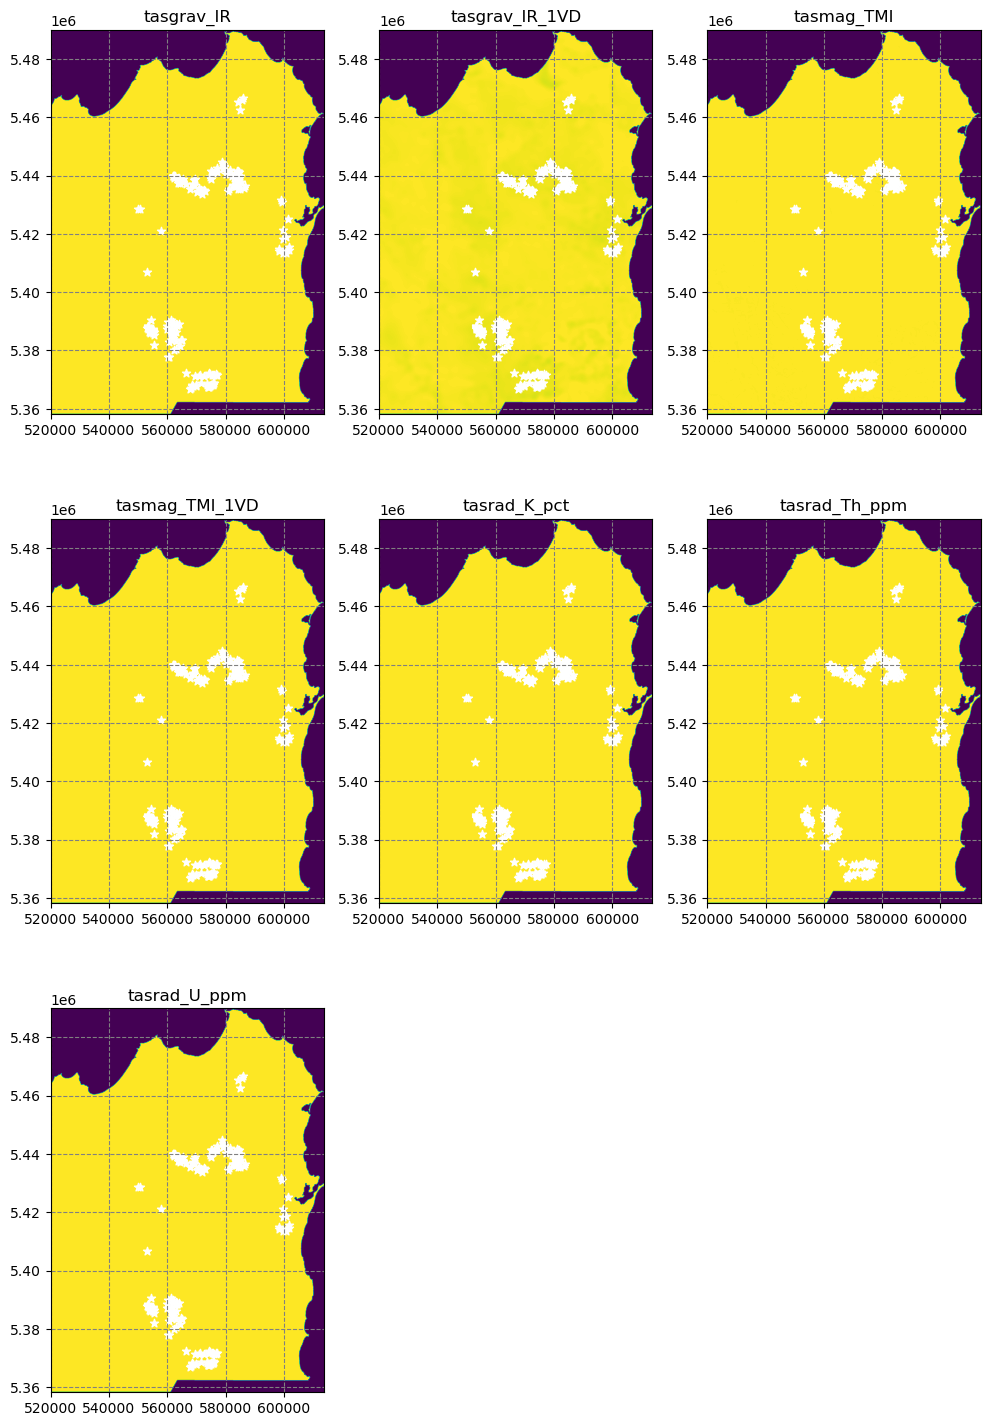

In [6]:
# plot the data
fig, axes = plt.subplots(3,3,figsize=(12,18))
for i, ax in enumerate(axes.flatten()):
    if i < data.shape[0]:
        ax.imshow(data[i], vmin=np.nanpercentile(data[i], 5), 
                  vmax=np.nanpercentile(data[i], 95), extent=region)
        ax.set(title=names[i])
        gdf.plot(ax=ax, marker='*', facecolor='w')
    else:
        ax.axis('off')
plt.show()

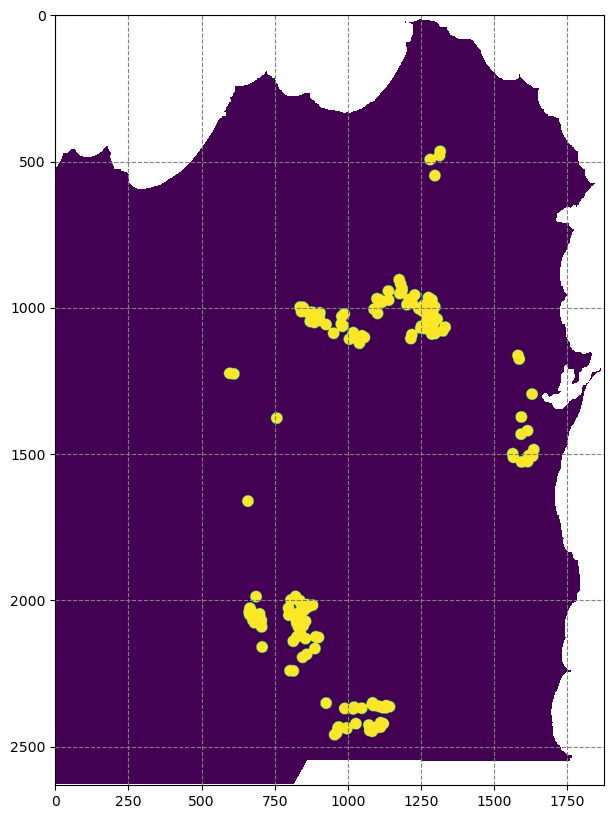

In [15]:
from rasterio.features import rasterize

# rasterize the point
geometry_generator = ((geom, 1) for geom in gdf.buffer(1000).geometry)
labels = rasterize(shapes=geometry_generator, out_shape=data[0].shape, 
                   fill=0, transform=transform).astype('float32')
labels[ndv_mask] = np.nan

plt.imshow(labels)

In [16]:
# convert 3D data cube to 2D tabular array
X_pix = data.reshape((data.shape[0], data.shape[1] * data.shape[2])).T
y_pix = labels.flatten()

# remove nans
X = X_pix[~np.isnan(y_pix)]
y = y_pix[~np.isnan(y_pix)]

X.shape, y.shape

((4002948, 7), (4002948,))

In [17]:
# import modelling modules
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# generate train and testing subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=420)

# define model
model1 = RandomForestClassifier(n_jobs=-1)
model1.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1)

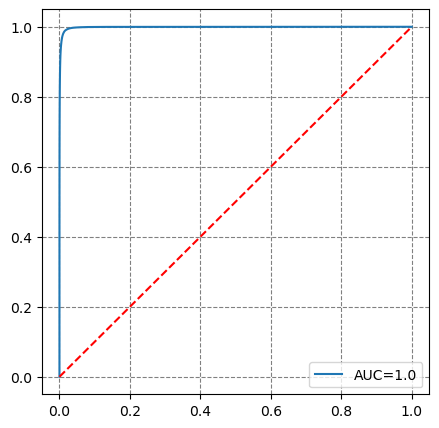

In [18]:
from sklearn.metrics import roc_curve, auc

# evaluate model on test data
y_proba = model1.predict_proba(X_test)[:,1]
fpr, tpr, threshold = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# plot all this
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(fpr, tpr, label='AUC={}'.format(round(roc_auc, 2)))
ax.plot([0,1], [0,1], 'r--')
ax.legend()
plt.show()

In [19]:
def get_proba_map(X_pix, nodata_mask, model):
    # remove nulls
    X = X_pix[np.invert(nodata_mask.flatten())]
    # get predictions
    predictions = model.predict_proba(X)[:,1]
    # create output array
    pred_ar = np.zeros(shape=nodata_mask.flatten().shape, dtype='float32')
    # insert predictions
    pred_ar[np.invert(nodata_mask.flatten())] = predictions
    # reshape to spatial
    pred_ar = pred_ar.reshape(nodata_mask.shape)
    pred_ar[nodata_mask] = np.nan
    return pred_ar
    
pred_ar1 = get_proba_map(X_pix, ndv_mask, model1)

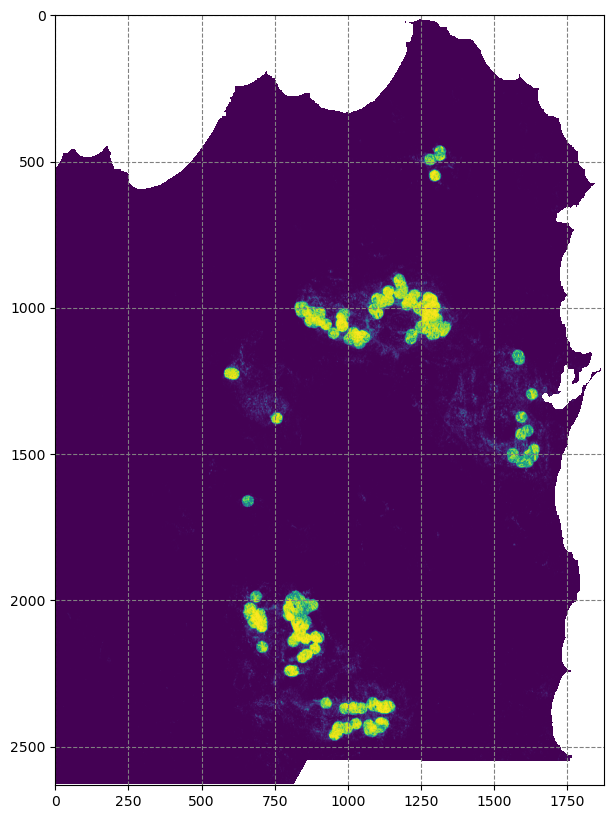

In [20]:
plt.imshow(pred_ar1)

In [22]:
# import random undersampler
from imblearn.under_sampling import RandomUnderSampler

# stratify classes with random undersampler
rus = RandomUnderSampler(random_state=32)
X_strat, y_strat = rus.fit_resample(X, y)

# generate training and testing set
X_train, X_test, y_train, y_test = train_test_split(X_strat, y_strat, test_size=0.33, random_state=42)

# define model and fit it
model2 = RandomForestClassifier(n_jobs=-1)
model2.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1)

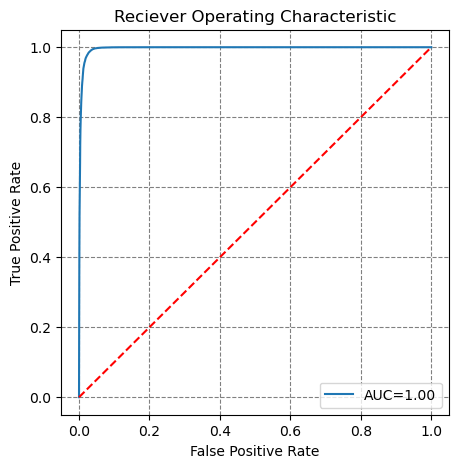

In [23]:
# evaluate the model on the test data set
y_preds = model2.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_preds[:,1])
roc_auc = auc(fpr, tpr)

# visualise this
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(fpr, tpr, label='AUC=%0.2f' % roc_auc)
ax.plot([0,1], [0,1], 'r--')
ax.set(title='Reciever Operating Characteristic', 
       ylabel='True Positive Rate', xlabel='False Positive Rate')
ax.legend()
plt.show()

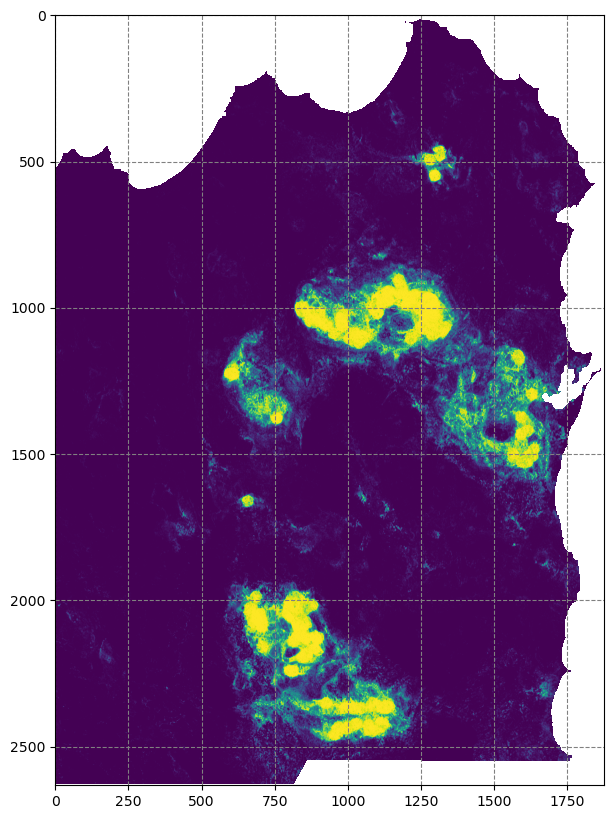

In [25]:
pred_ar2 = get_proba_map(X_pix, ndv_mask, model2)
plt.imshow(pred_ar2)

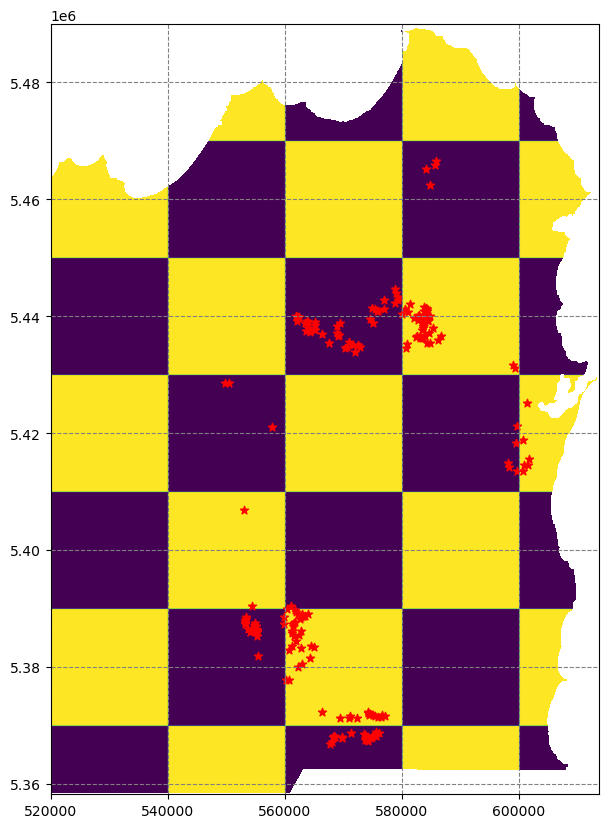

In [27]:
# define checkerboard function 
def make_checkerboard(boardsize, squaresize):
  '''
  props to stackoverflow user Blubberguy22, posted March 17, 2020 at 19:00
  https://stackoverflow.com/questions/2169478/how-to-make-a-checkerboard-in-numpy
  '''
  return np.fromfunction(lambda i, j: (i//squaresize[0])%2 != (j//squaresize[1])%2, boardsize).astype('float32')

# make checkerboard
checker = make_checkerboard(data[0].shape, (400,400))
checker[ndv_mask] = np.nan

#plot checkerboard
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(checker, extent=region)
gdf.plot(ax=ax, marker='*', facecolor='r')
plt.show()

In [28]:
checker.shape

(2633, 1876)

In [29]:
checker

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [ 0.,  0.,  0., ..., nan, nan, nan],
       [ 0.,  0.,  0., ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

In [30]:
np.unique(checker)

array([ 0.,  1., nan], dtype=float32)

In [31]:
# data into checkers
X_check0 = X_pix[checker.flatten()==0]
y_check0 = y_pix[checker.flatten()==0]

X_check1 = X_pix[checker.flatten()==1]
y_check1 = y_pix[checker.flatten()==1]

In [32]:
# remove nans
X_check0 = X_check0[~np.isnan(y_check0)]
y_check0 = y_check0[~np.isnan(y_check0)]

X_check1 = X_check1[~np.isnan(y_check1)]
y_check1 = y_check1[~np.isnan(y_check1)]

In [36]:
# print some details
print ('Checker 0: X data array shape is {}, y labels array shape is {}'.format(X_check0.shape, y_check0.shape))
print ('Checker 1: X data array shape is {}, y labels array shape is {}'.format(X_check1.shape, y_check1.shape))

# run undersampling
X_check0, y_check0 = rus.fit_resample(X_check0, y_check0)
X_check1, y_check1 = rus.fit_resample(X_check1, y_check1)

# print some details
print ('Checker 0: X data array shape is {}, y labels array shape is {}'.format(X_check0.shape, y_check0.shape))
print ('Checker 1: X data array shape is {}, y labels array shape is {}'.format(X_check1.shape, y_check1.shape))


Checker 0: X data array shape is (114860, 7), y labels array shape is (114860,)
Checker 1: X data array shape is (106618, 7), y labels array shape is (106618,)
Checker 0: X data array shape is (114860, 7), y labels array shape is (114860,)
Checker 1: X data array shape is (106618, 7), y labels array shape is (106618,)


In [37]:
# fit some models
model3 = RandomForestClassifier(n_jobs=-1)
model4 = RandomForestClassifier(n_jobs=-1)

model3.fit(X_check0, y_check0)
model4.fit(X_check1, y_check1)

RandomForestClassifier(n_jobs=-1)

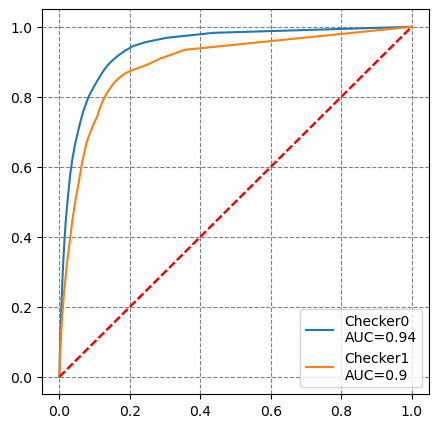

In [38]:
# get roc_curve data
roc_data = []
for model, X_check, y_check in zip([model3, model4],[X_check1, X_check0],[y_check1, y_check0]):
    y_pred = model.predict_proba(X_check)[:,1]
    fpr, tpr, _ = roc_curve(y_check, y_pred)
    roc_auc = auc(fpr, tpr)
    roc_data.append((fpr, tpr, roc_auc))
    
# plot all this 
fig, ax = plt.subplots(figsize=(5,5))
for i, (fpr, tpr, roc_auc) in enumerate(roc_data):
    ax.plot(fpr, tpr, label='Checker{}\nAUC={}'.format(i, round(roc_auc,2)))
    ax.plot([0,1], [0,1], 'r--')
    ax.legend()
plt.show()

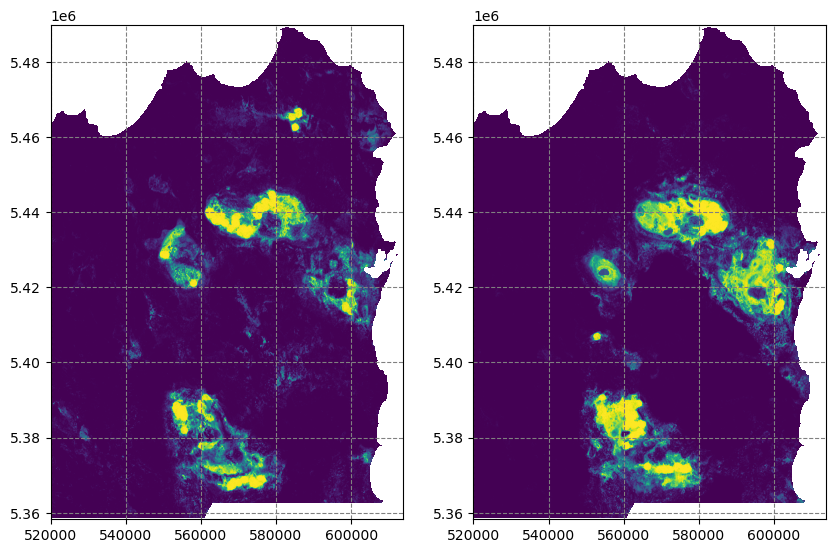

In [40]:
# generate probability maps
pred_ar3 =  get_proba_map(X_pix, ndv_mask, model3)
pred_ar4 = get_proba_map(X_pix, ndv_mask, model4)

# plot probability maps
fig, ax = plt.subplots(1,2,figsize=(10,10))
for i, ar in enumerate([pred_ar3, pred_ar4]):
    ax[i].imshow(ar, extent=region)
#     df.plot(ax=ax[i], marker='*', facecolor='w')
plt.show()

/home/joseph/miniconda3/envs/dev/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


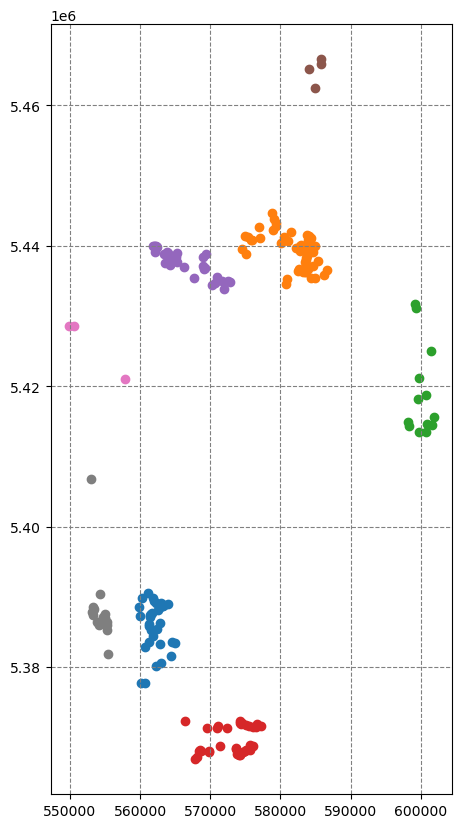

In [42]:
# import kmeans clustering 
from sklearn.cluster import KMeans

# get occurence points
xy_pnts = [[geom.x, geom.y] for geom in gdf.geometry]
kmeans_obj = KMeans(n_clusters=8).fit(xy_pnts)
gdf['labels'] = kmeans_obj.labels_ +1

# plot clustered points
fig, ax = plt.subplots(figsize=(10,10))
for c in sorted(gdf.labels.unique()):
    gdf[gdf.labels==c].plot(ax=ax)
#     ax.legend()
plt.show()

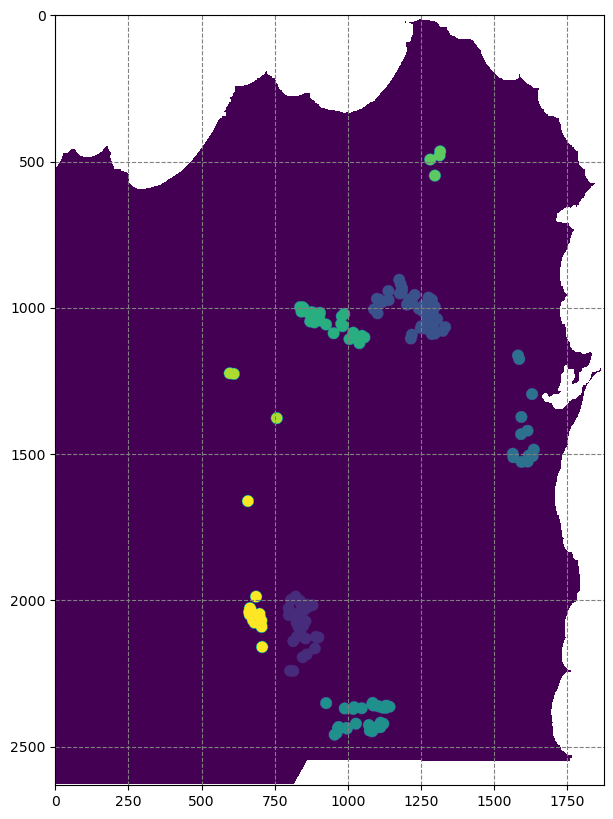

In [43]:
# generate raster label
geometry_generator = ((geom, c) for c, geom in zip(gdf.labels, gdf.buffer(1000).geometry))
clustermap = rasterize(shapes=geometry_generator, out_shape=data[0].shape, fill=0, transform=transform).astype('float32')
clustermap[ndv_mask] = np.nan

plt.imshow(clustermap)

In [44]:
# create a data selection function
def cluster_pixel_selection(clustermap, data_cube, class_1_list):
  X = data_cube.reshape((data_cube.shape[0], data_cube.shape[1] * data_cube.shape[2])).T
  y = clustermap.flatten() 
  X = X[~np.isnan(y)]
  y = y[~np.isnan(y)]
  y[np.isin(y, class_1_list)] = 1
  y[y!=1] = 0
  return X, y

# create a function to fit a model to input data
def fit_stratifiedrandomforest(X, y):
  X, y = rus.fit_resample(X, y)
  model = RandomForestClassifier(n_estimators=15, n_jobs=-1)
  return model.fit(X, y)

# define a function to determine performance on holdout occurence clusters
def holdout_roc_auc(clustermap, data_cube, holdout_cluster_list, model_cluster_list, model):
  X = data_cube.reshape((data_cube.shape[0], data_cube.shape[1] * data_cube.shape[2])).T
  y = clustermap.flatten() 
  X = X[~np.isnan(y)]
  y = y[~np.isnan(y)]
  X = X[~np.isin(y, model_cluster_list)]
  y = y[~np.isin(y, model_cluster_list)]
  y[np.isin(y, holdout_cluster_list)] = 1
  # predict onto X
  y_pred = model.predict_proba(X)
  fpr, tpr, threshold = roc_curve(y, y_pred[:,1])
  roc_auc = auc(fpr, tpr)
  return fpr, tpr, roc_auc

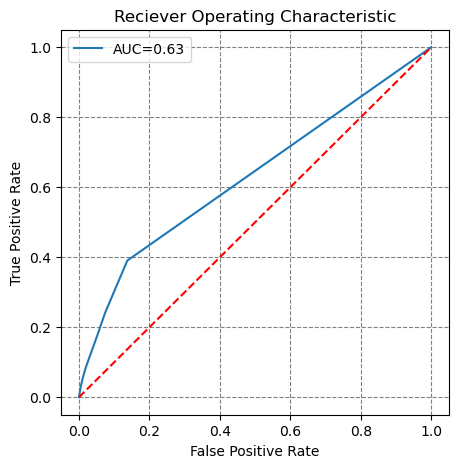

In [45]:
# train a model on cluster 1
X, y = cluster_pixel_selection(clustermap, data, [1])
model = fit_stratifiedrandomforest(X, y)
fpr, tpr, roc_auc = holdout_roc_auc(clustermap, data, [2,3,4,5,6,7,8], [1], model)

# visualise this
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(fpr, tpr, label='AUC={}'.format(round(roc_auc,2)))
ax.plot([0,1], [0,1], 'r--')
ax.set(title='Reciever Operating Characteristic', 
       ylabel='True Positive Rate', xlabel='False Positive Rate')
ax.legend()
plt.show()

In [47]:

# loop through clusters
models = []
fprs, tprs, roc_aucs = [], [], []
for i in sorted(gdf.labels.unique()):
    X, y = cluster_pixel_selection(clustermap, data, [j for j in range(1,9) if j!=i])
    model = fit_stratifiedrandomforest(X, y)
    fpr, tpr, roc_auc = holdout_roc_auc(clustermap, data, [i], [j for j in range(1,9) if j!=i], model)
    models.append(model)
    fprs.append(fpr)
    tprs.append(tpr)
    roc_aucs.append(roc_auc)

In [49]:
# loop through models and get probability maps
prob_maps = []
for m in models:
    prob_maps.append(get_proba_map(X_pix, ndv_mask, m))

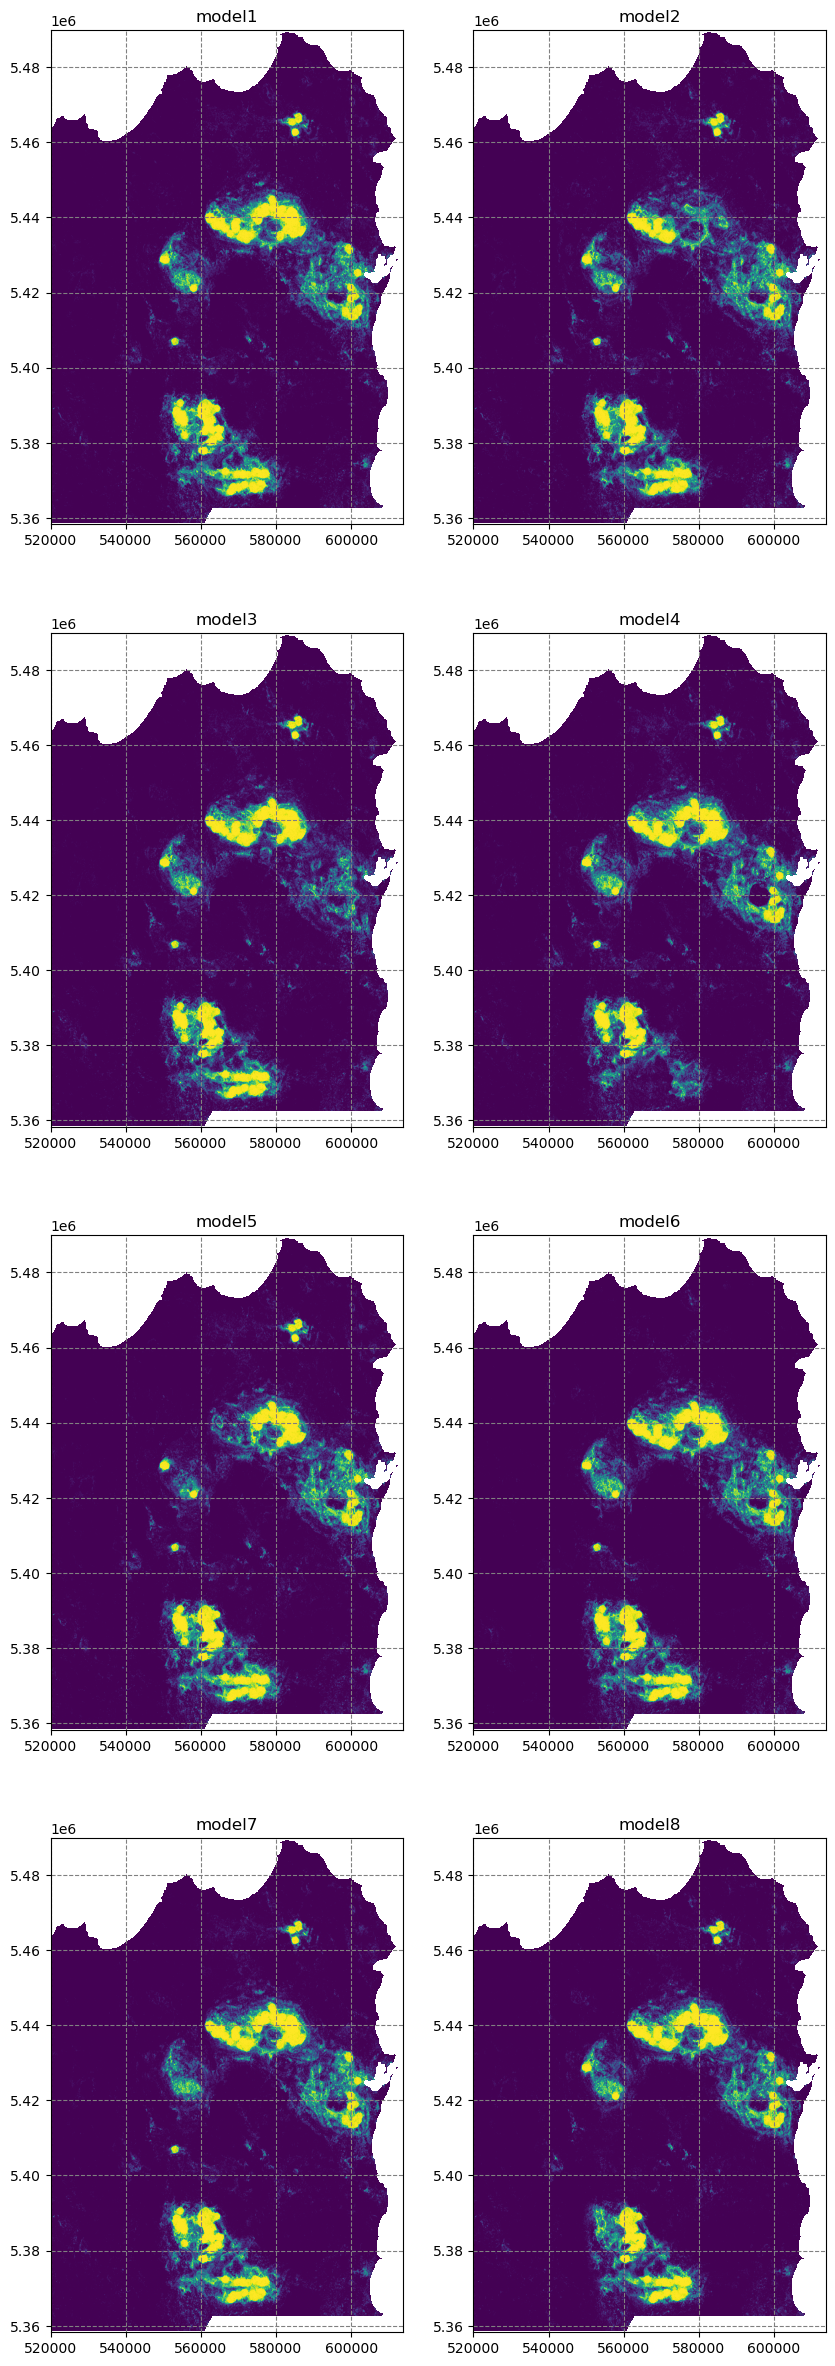

In [50]:
# plot all models
fig, axes = plt.subplots(4,2, figsize=(10,30))
for i, ax in enumerate(axes.flatten()):
    im = ax.imshow(prob_maps[i], extent=region)
    ax.set(title='model'+str(i+1))
plt.show()